# Bias - Variance tradeoff and Polynomial regression

The objective of the following article is to explore the relationship between two competing properties of a statistical learning model: **bias** and **variace**.

An important concept in machine learning is the **bias-variance** tradeoff. Model with high bias are not complex enough for the data and then to underfit, whilst models with high variance overfit to the training data. 

The *variance* consists in the amount by which a model changes when we train it on a different data set. It is expected that the fitted method varies according to the data it is fed with, nevertheless the change shouldn't be significant. If this is not the case the model is generally too flexible and is said to have *high variance*.

On the other hand, the *bias* is the error introduced when we try to model a real world problem, which may be very complicated, with a too simple approximation. 

So the **goal** is to create a model which can find a **tradeoff** between *bias* and *variace*.

To better understand the problem we will do an example. In this example we try to predict the water flowing out of a dam using the change in water level of an external reservoir.

As a general rule, the more we increase the flexibity of a method, the more the variance increases and the bias decreases. The rate at which the two properties change is not the same though and it is crucial to study their relative fluctuation to find the sweet spot minimizing the total model error. 

### The water and the dam

As announced above we will build a predictive model to forecast the amount of water getting out of a dam. We will do this playing around with Linear Regression at first drawing a straight line and later on extending the feature space with the addition of p-th degree polynomials of X.

First recall the regularized cost function and its gradient for Linear Regression:

$J(\theta) = \frac{1}{2m} \sum_{i=1}^{m} (h_\theta(x^{(i)}) - y^{(i)})^2 + \frac{\lambda}{2m}\sum_{j=1}^n\theta_j^2$

$\frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m} \sum_{i=1}^{m} (h_\theta(x^{(i)}) - y^{(i)}) x_j^{(i)} $ for $j=0$

$\frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^{m} (h_\theta(x^{(i)}) - y^{(i)}) x_j^{(i)} + \frac{\lambda}{m}\sum_{j=1}^n\theta_j$ for $j\geq1$

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
from scipy import optimize
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (18, 12)

In [35]:
mat = scipy.io.loadmat('ex5data1.mat')
X = mat['X']
print(X.shape)
y = mat['y']
print(y.shape)
X_val = mat['Xval']
print(X_val.shape)
y_val = mat['yval']
print(y_val.shape)
X_test = mat['Xtest']
print(X_test.shape)
y_test = mat['ytest']
print(y_test.shape)

(12, 1)
(12, 1)
(21, 1)
(21, 1)
(21, 1)
(21, 1)


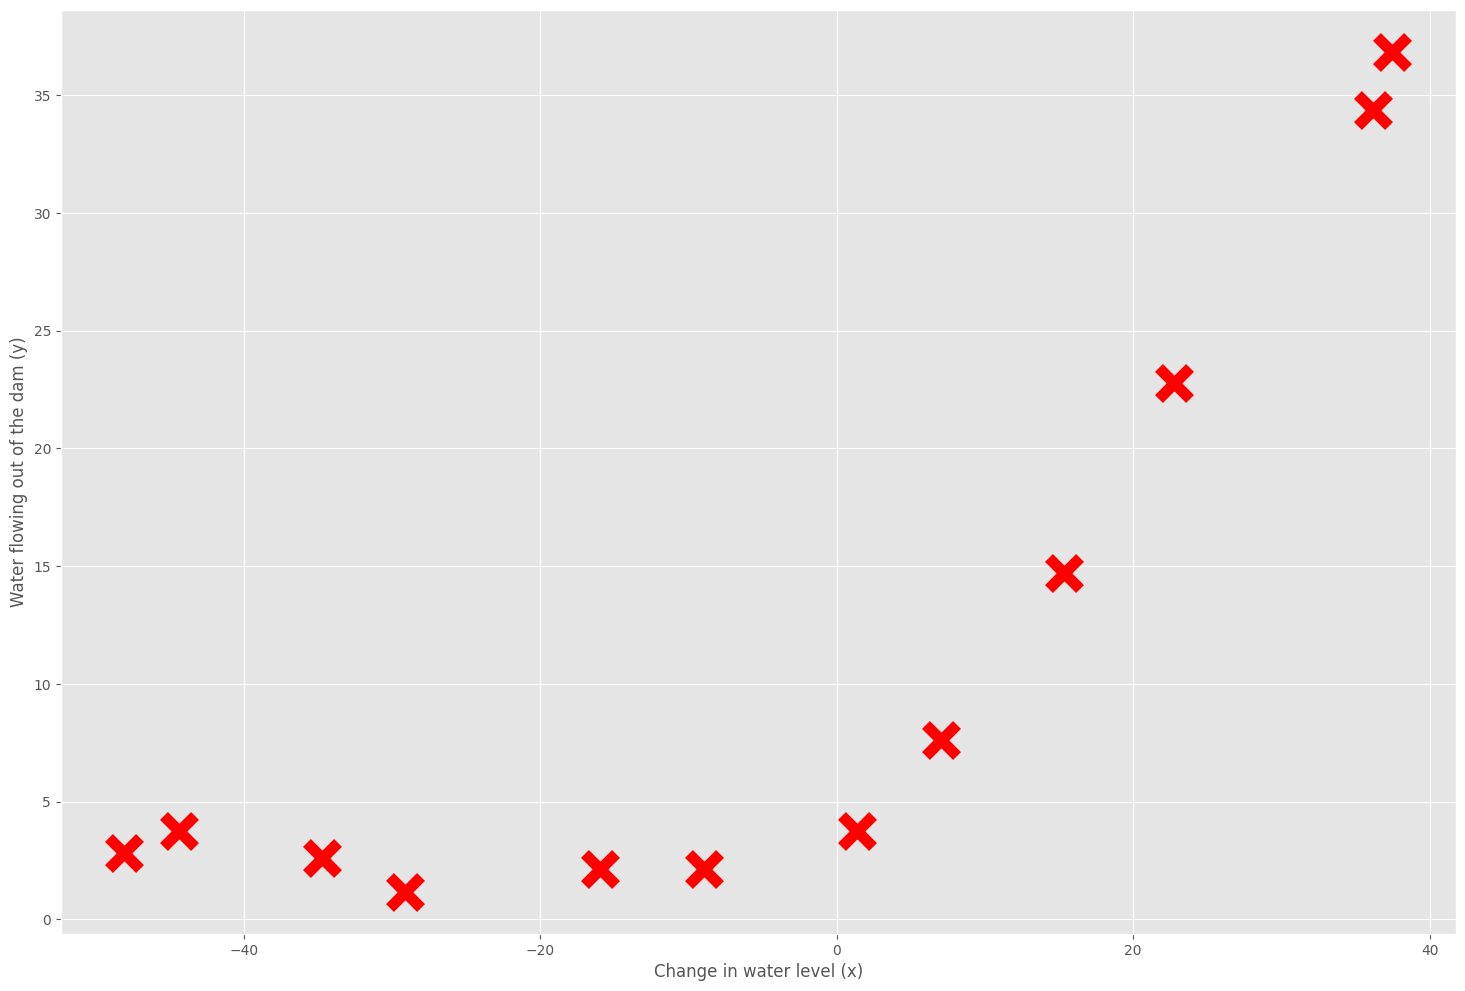

In [10]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1) 
ax.scatter(X, y, s=500, marker='x',color='r',linewidths=8)
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.show()

It can se seen that the relation between X and y is not linear. Nevertheless, for the purpose of experimenting with ML we will fit a linear model and check the results we get.

Below there are some useful functions that we will use throughout this article.

### Functions

In [11]:
def costFunctionReg(theta, X, y, lamda):
    m = y.shape[0]
    h_y = X.dot(theta) - y
    cost = (1/(2*m)) * (sum(h_y**2)) + (lamda/(2*m))*(sum(theta[1:]**2))
    return cost

def computeGradientReg(theta, X, y, lamda):
    theta = theta.reshape(-1, 1)
    m = y.shape[0]
    h_y = X.dot(theta) - y
    grad = 1/m * (h_y).T.dot(X)
    grad[1:] = grad + lamda/m*theta[1:].T
    return grad

def gradientDescent(X, y, theta, alpha, num_iters, lamda):
    m = y.shape[0]
    J_history = np.zeros((num_iters, 1))
    for i in range(num_iters):
        h_y = X.dot(theta) - y
        gradient = (alpha/m)*((X.T).dot(h_y))
        gradient[1:] = gradient[1:] + (lamda/m*theta[1:])
        theta = theta - gradient
        J_history[i] = costFunctionReg(theta, X, y, lamda)
       
    return theta, J_history

def learningCurve(X, y, Xval, yval, lamda):
    m =  X.shape[0]
    initial_theta = np.ones((X.shape[1], 1))
    error_train = np.zeros((m, 1))
    error_val = np.zeros((m, 1))
    for i in range(m):
        theta = gradientDescent(X[0:i+1], y[0:i+1], initial_theta, 0.001, 3000, lamda)[0]
        error_train[i] = costFunctionReg(theta, X[0:i+1], y[0:i+1], lamda)
        error_val[i] = costFunctionReg(theta, Xval, yval, lamda)
    return error_train, error_val

def polyFeatures(X, p):
    for i in np.arange(1, p + 1):
        X = np.c_[X, X[:, 0]**i]
    return X

def featureNormalize(X):
    average = np.mean(X, axis=0)
    sigma = np.std(X, axis=0)
    X_norm = (X - average)/sigma
    return X_norm, average, sigma

def plotFit(min_X, max_X, mu, sigma, p):
    X = np.arange(min_X - 15, max_X + 15, 0.05).reshape(-1,1)
    X_poly = polyFeatures(X, p)
    X_poly = (X_poly - mu) / sigma
    X_poly = np.c_[np.ones(X_poly.shape[0]), X_poly]
    return X, X_poly

def validationCurve(X, y, Xval, yval, lambda_vec):
    m = lambda_vec.size
    error_train = np.zeros((m, 1))
    error_val = np.zeros((m, 1))
    initial_theta = np.zeros((X.shape[1], 1))
    alpha = 0.001
    num_iters = 3000
    for i, lamda in enumerate(lambda_vec):
        theta = gradientDescent(X, y, initial_theta, alpha, num_iters, lamda)[0]
        error_train[i] = costFunctionReg(theta, X, y, 0)
        error_val[i] = costFunctionReg(theta, Xval, yval, 0)
    best_lamda = lambda_vec[error_val.argmin()]
    return error_train, error_val, best_lamda

## High Bias model

Now we are ready to run Linear Regression. To minimaze Linear Regression cost function we use *gradient descent* algorithm which we have just implemented above. We set our initial parameters `initial_theta` to one and the regualarization parameter `lamda` to zero since in this section we do not want to regularize our model.

In [12]:
# add bias term
X = np.c_[np.ones(X.shape[0]), X]

# regularization parameter
lamda = 0

initial_theta = np.ones((X.shape[1], 1))
num_iters = 3000
alpha = 0.001
theta, J_history = gradientDescent(X, y, initial_theta, alpha, num_iters, lamda)
print("Theta found by gradient descent: intercept={0}, slope={1}".format(theta[0],theta[1]))

Theta found by gradient descent: intercept=[12.42957875], slope=[0.36383098]


To check that *gradient descent* have worked properly, we plot the cost value of the cost function to make sure it non increase with each iteration of gradient descent.

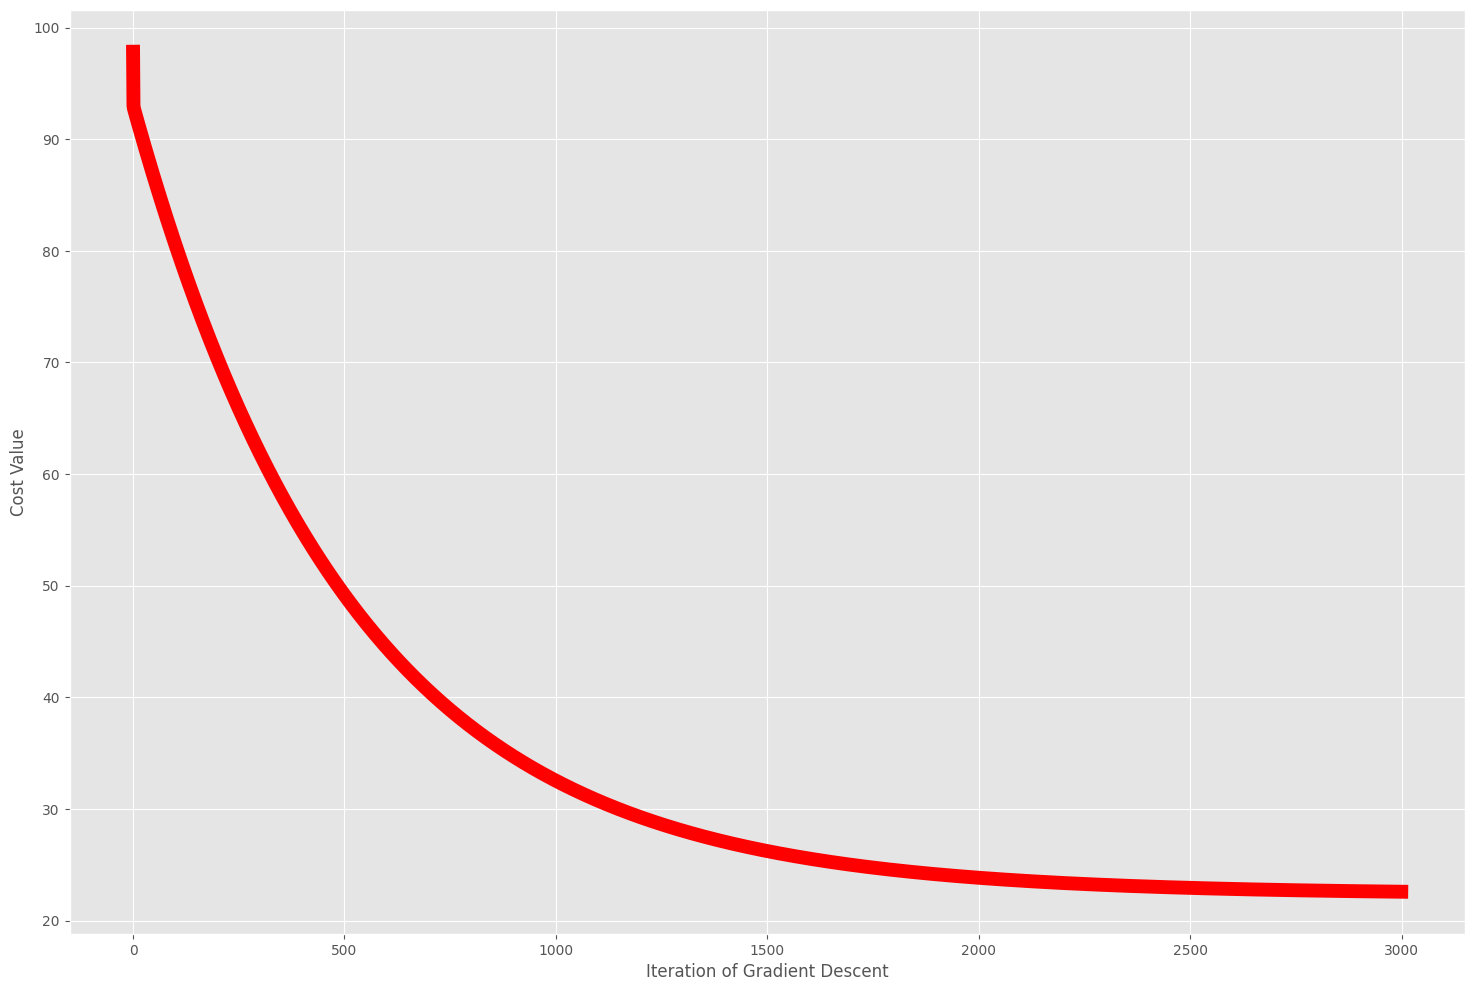

In [13]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(range(num_iters), J_history, linewidth=10, c='r')
plt.ylabel('Cost Value')
plt.xlabel('Iteration of Gradient Descent')
plt.show()

The cost is decreasing with each iteration, good!

Now is the moment to plot the fit line.

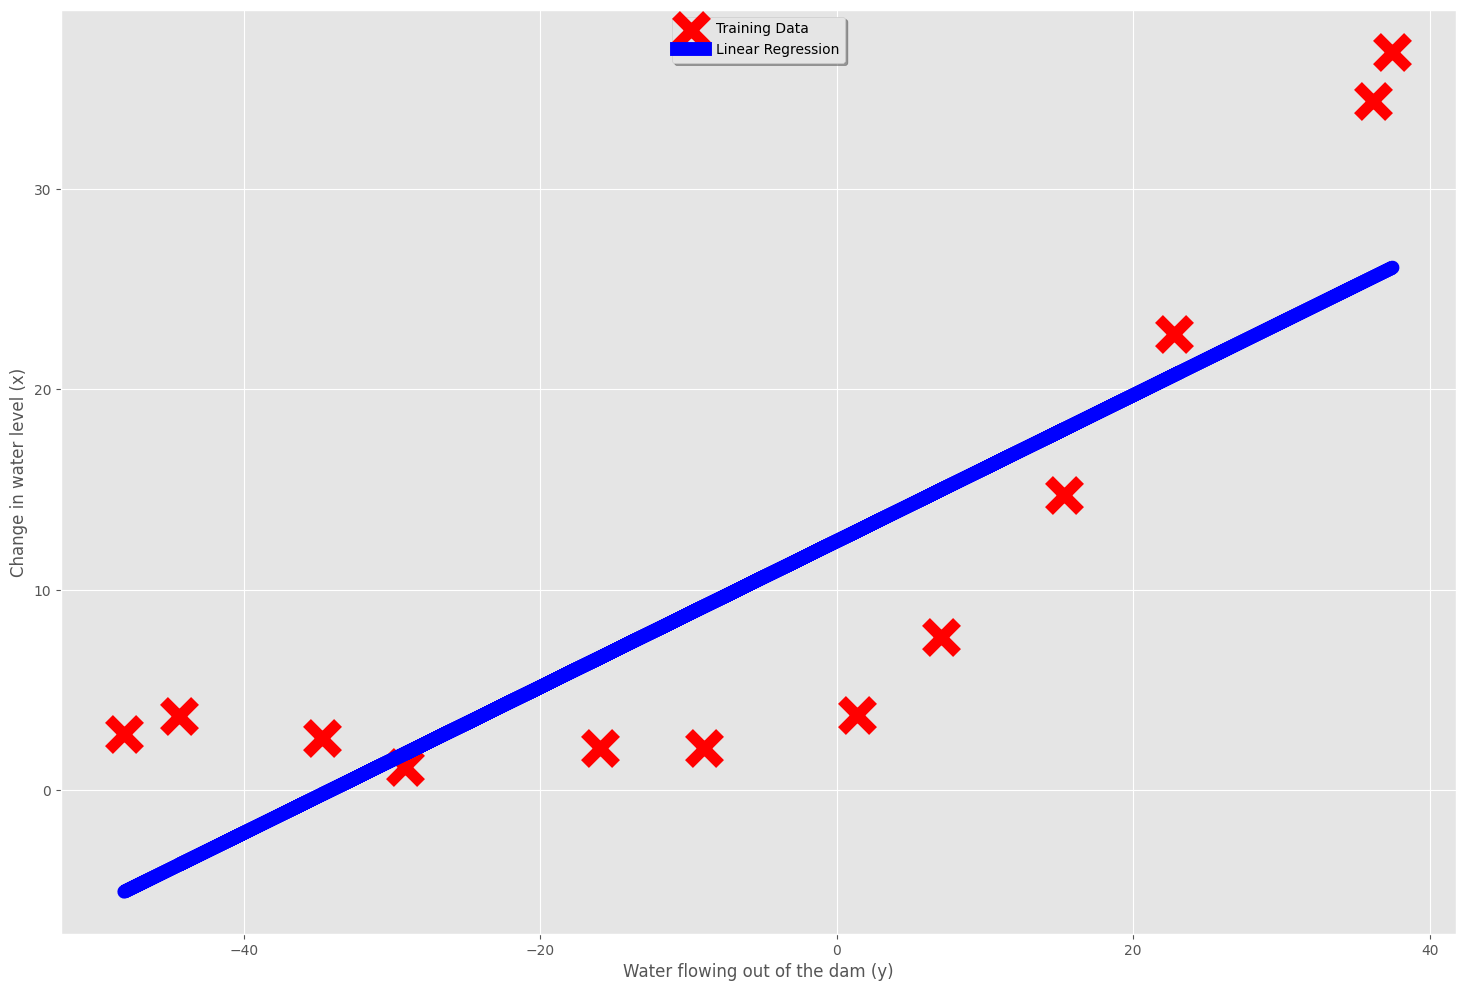

In [14]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1) 
ax.scatter(X[:, 1], y[:, 0], s=500, marker='x',color='r',linewidths=8, label='Training Data')
ax.plot(X[:,1], np.matmul(X, theta), linestyle='-', label='Linear Regression', linewidth=10, c='b')
# set the legend for the labels: 'Training Data' and 'Linear Regression'
legend = ax.legend(loc='upper center', shadow=True)
plt.ylabel('Change in water level (x)')
plt.xlabel('Water flowing out of the dam (y)')
plt.show()

It is evident that a straight line does not model the true relationship between X and y. The method is not flexible enough, resulting in **high bias** and **low variance**. The finding is proved by the below learning curve as well.

### Learning curve

A **learning curve** is a useful method that shows the error on the training set v.s. validation set for an increasing number of data points ingested in the learning process. Let's call `learningCurve` function and plot the result.

In [15]:
# add bias term validation set
X_val = np.c_[np.ones((X_val.shape[0], 1)), X_val]

In [16]:
lamda = 0
error_train, error_val = learningCurve(X, y, X_val, y_val, lamda)

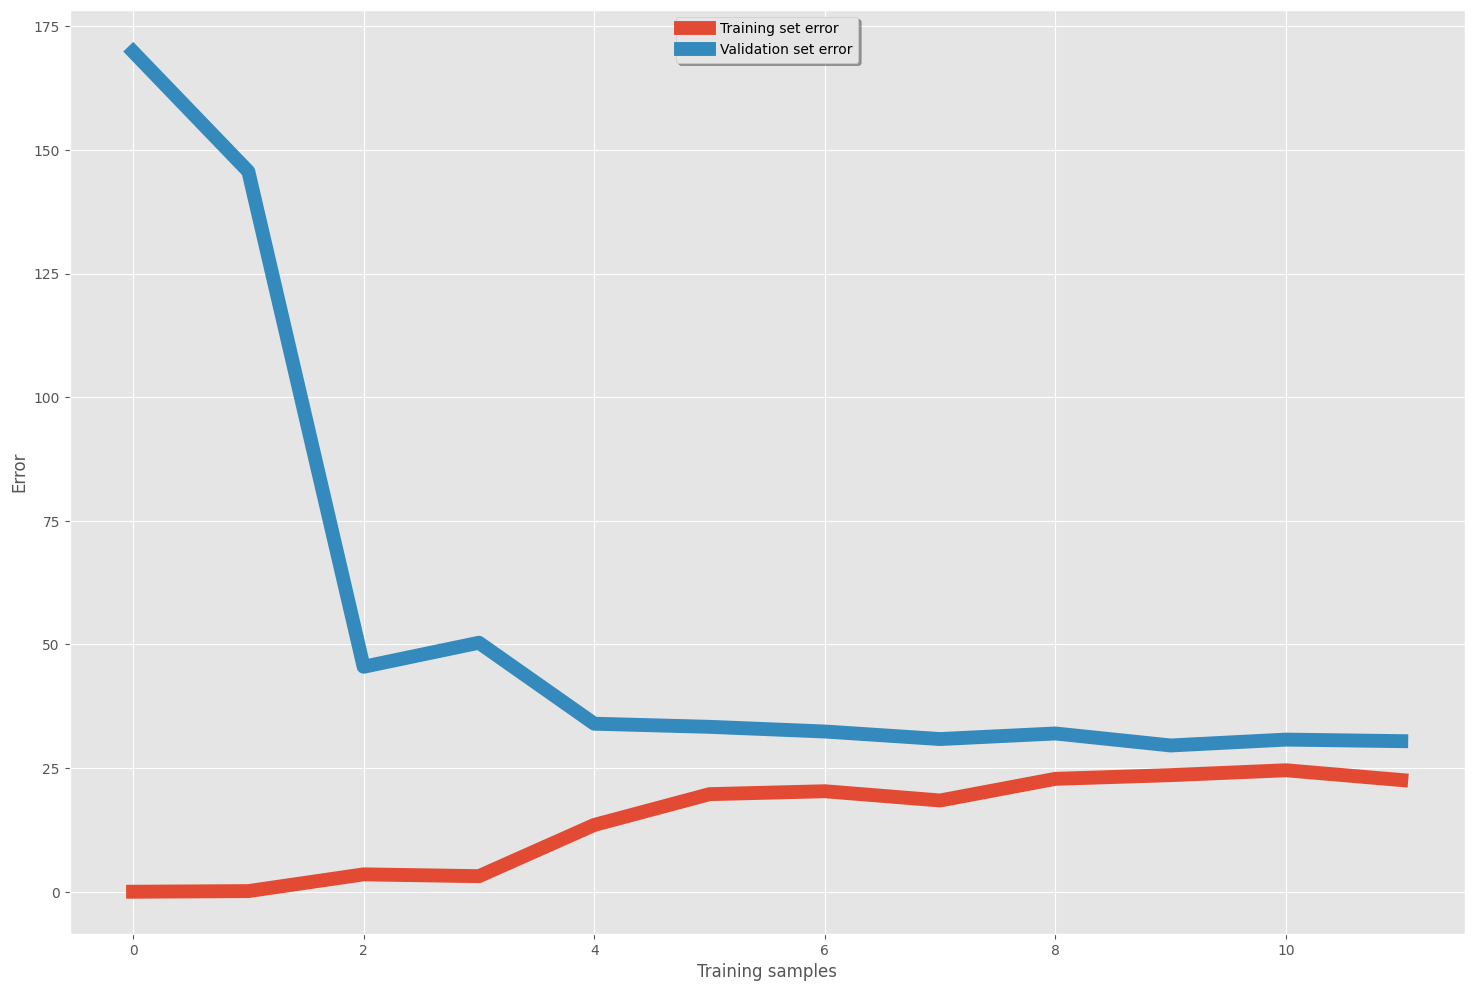

In [17]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(range(X.shape[0]), error_train, label = 'Training set error', linewidth=10)
ax.plot(range(X.shape[0]), error_val, label = 'Validation set error', linewidth=10)
legend = ax.legend(loc='upper center', shadow=True)
plt.ylabel('Error')
plt.xlabel('Training samples')
plt.show()

It can be observed that *both* the train error and cross validation error are high when the number of training examples is increased. As we already discovered before looking at the line that fits the training set, this reflects a **high bias** problem in the model, namely the linear regression model is too simple and is unable to fit our dataset well. To fit a better model we will implement **polynomial regression**.

# Polynomial regression

The problem with our linear model was that it was too simple for the data and resulted **underfitting** (high bias). In this part, we will address this problem by adding more features and our hypothesis will have the following form:

$h_\theta(x) = \theta_0 + \theta_1 * (waterLevel) + \theta_2 * (waterLevel)^2 + \dots + \theta_p * (waterLevel)^p =\theta_0 + \theta_1x_1 + \theta_2x_2 + \dots + \theta_px_p$ 

Notice that, by doing that mapping, we obtain a linear regression model where the features are the various powers of the original value (waterLevel).

To achieve that, we use the function `polyFeatures` which takes in input the dataset we want to add polynomial features and the max polynomial degree.
It turns out that if we run the training directly using the new dataset we obtained, will not work well as the features would be badly scaled. Therefore is necessary to use feature normalization. To do that, we used the function `featureNormalize`. This function returns the normalized dataset, the *mean* and the *standard deviation* (represented by `sigma` variable in the code). We need the mean and standard deviation for normalize subsequently the validation and test set.

## High Variance model

In [18]:
mat = scipy.io.loadmat('ex5data1.mat')
X = mat['X']
y = mat['y']
X_val = mat['Xval']
y_val = mat['yval']
X_test = mat['Xtest']
y_test = mat['ytest']

In [19]:
p = 10

X_poly = polyFeatures(X, p)
# it is important to normalize and scale our dataset before applying any ML on it
X_poly, mean, sigma = featureNormalize(X_poly)
# add biad term to our new dataset
X_poly = np.c_[np.ones((X_poly.shape[0], 1)), X_poly]

X_poly_val = polyFeatures(X_val, p)
X_poly_val = (X_poly_val - mean) / sigma
X_poly_val = np.c_[np.ones((X_poly_val.shape[0], 1)), X_poly_val]

X_poly_test = polyFeatures(X_test, p)
X_poly_test = (X_poly_test - mean) / sigma
X_poly_test = np.c_[np.ones((X_poly_test.shape[0], 1)), X_poly_test]

Normalized our datasets, we can run Linear Regression on the polynomial dataset and see how good our line fits the model.

In [20]:
lamda = 0
alpha = 0.001
num_iters = 3000
initial_theta = np.ones((X_poly.shape[1], 1))
theta_fit_poly, J_history_poly = gradientDescent(X_poly, y, initial_theta, alpha, num_iters, lamda)

/var/folders/26/pjvmws_s7xxbzf69k0n7_8p80000gp/T/ipykernel_3364/4191164049.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X = np.arange(min_X - 15, max_X + 15, 0.05).reshape(-1,1)


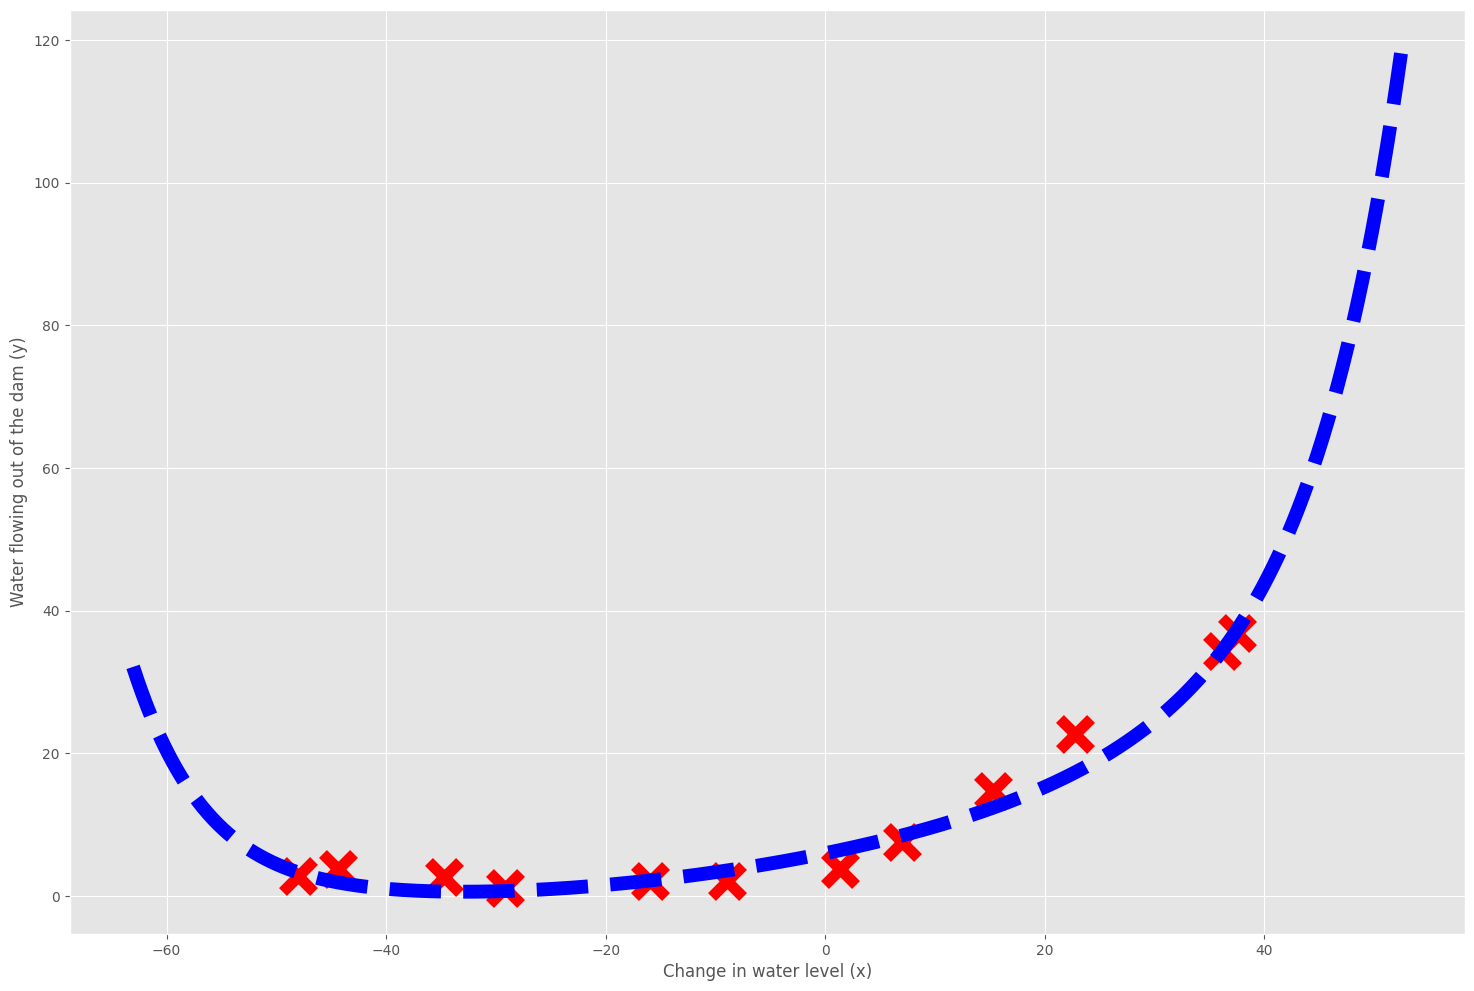

In [21]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1) 
ax.scatter(X, y, s=500, marker='x',color='r',linewidths=8)
X_fit, X_poly_fit = plotFit(min(X), max(X), mean, sigma, p)
ax.plot(X_fit, np.dot(X_poly_fit, theta_fit_poly), '--', color='blue', linewidth=10)
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.show()

The problem with our linear model was that it was too simple for the data and resulted in underfitting (high bias).
The polynomial fit, on the contrary, is able to follow the datapoints very well - thus, obtaining a low training error. However, the polynomial method is very complex and even drops off at the extremes. This is an indicator that the polynomial regression model is **overfitting** the training data and will not generalize well.

To better understand the problems with the unregularized model ($\lambda = 0$), you can see that the learning curve plot blow shows the same effect where the training error is low, but the validation error is high. There is a gap between the training and cross validation errors, indicating a **high variance** problem

In [22]:
lamda = 0
error_train_poly, error_val_poly = learningCurve(X_poly, y, X_poly_val, y_val, lamda)

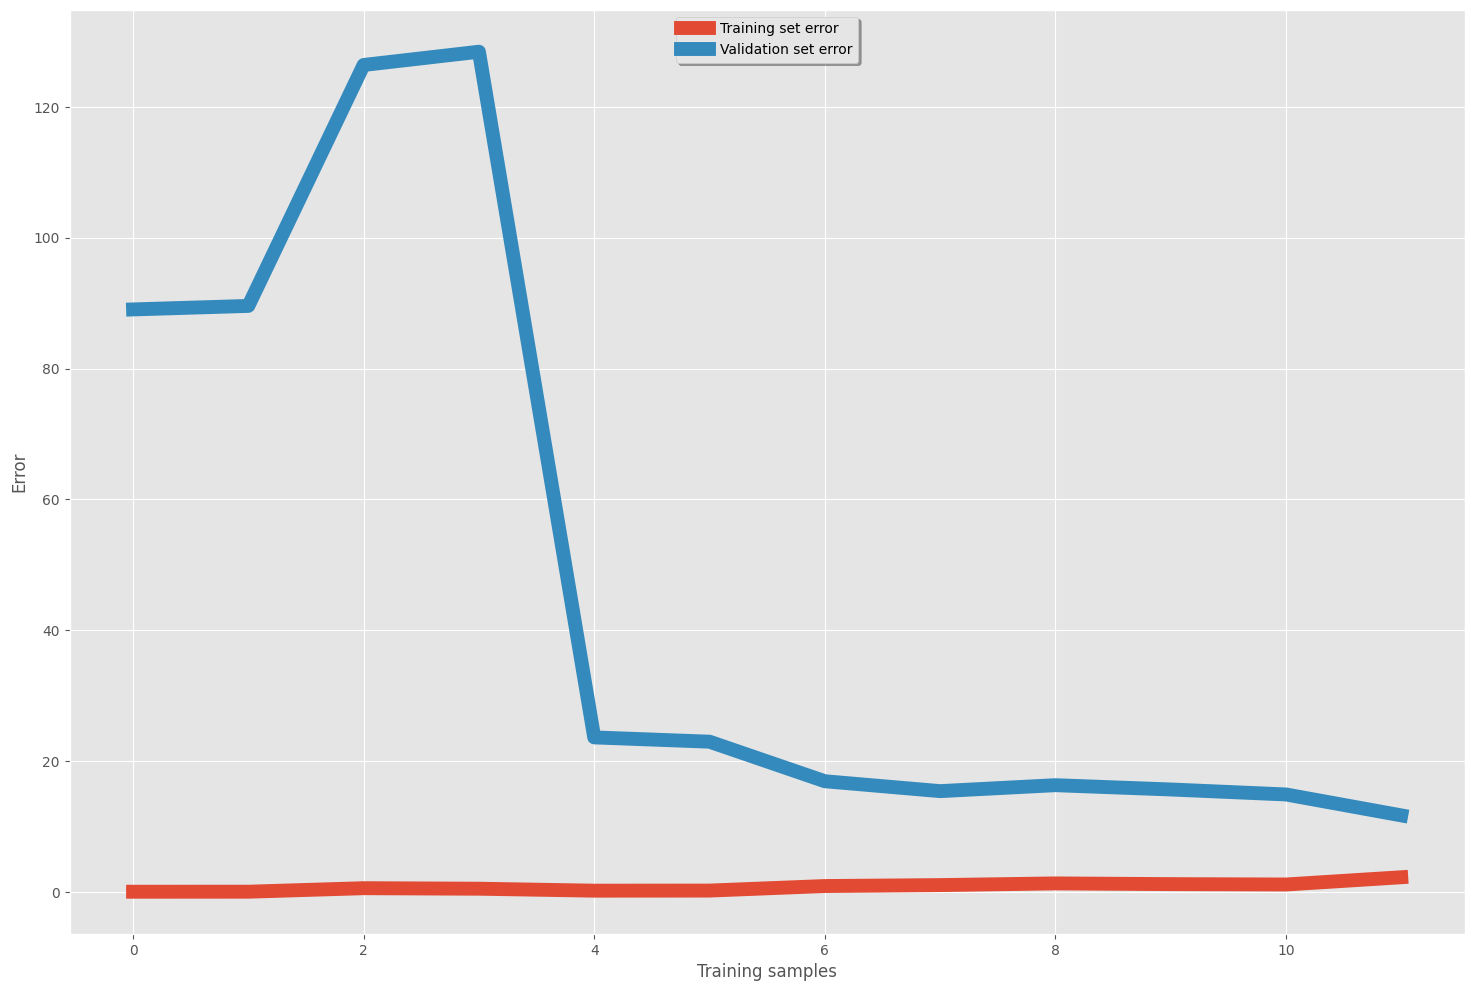

In [23]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(range(X_poly.shape[0]), error_train_poly, label = 'Training set error', linewidth=10)
ax.plot(range(X_poly.shape[0]), error_val_poly, label = 'Validation set error', linewidth=10)
legend = ax.legend(loc='upper center', shadow=True)
plt.ylabel('Error')
plt.xlabel('Training samples')
plt.show()

To remedy the situation we have to reduce the variance. **Regularization** come to the rescue; specifically now we are going to apply the *validation set approach* to select the *best* value of lambda that minimize the validation set error. <br>
Minimizing that validation set error means we created a model with no bias and no variance, which is our goal!

### Regularize the model selecting $\lambda$ using a cross validation set

$\lambda$ is a regularization parameter which controls the degree of regularization (thus, helps preventing overfitting). The regularization term puts a penalty on the overall cost $J$. As the magnitudes of the model parameters $\theta_j$ increase, the penalty increases as well.

The regularization parameter $\lambda$ can significantly affect the results of regularized polynomial regression on the training and cross validation set. In particular, a model without regularization ($\lambda = 0$) fits the trainig set well, but does not generalize. Conversely, a model with too much regularization ($\lambda = 100$) does not fit the training set and testing set well. A good choice of $\lambda$ (e.g., $\lambda = 1$) can provide a good fit to the data.
So we have to implememt an automated method to select the $\lambda$ parameter. Concretely, we will use a cross validation set to evaluate how good each $\lambda$ value is.

After selecting the best $\lambda$ value using the cross validation set, we can then evaluate the model on the test set to estimate how well the model will perform on actual unseen data.
To achieve that, the function `validationCurve` does this job. This function takes in input a list of values to try (*lambda_vec*) along with the training and validation set.

In [24]:
lambda_vec = np.array([0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10])
train_error_lamb, validation_error_lamb, best_lamda = validationCurve(X_poly, y, X_poly_val, y_val, lambda_vec)

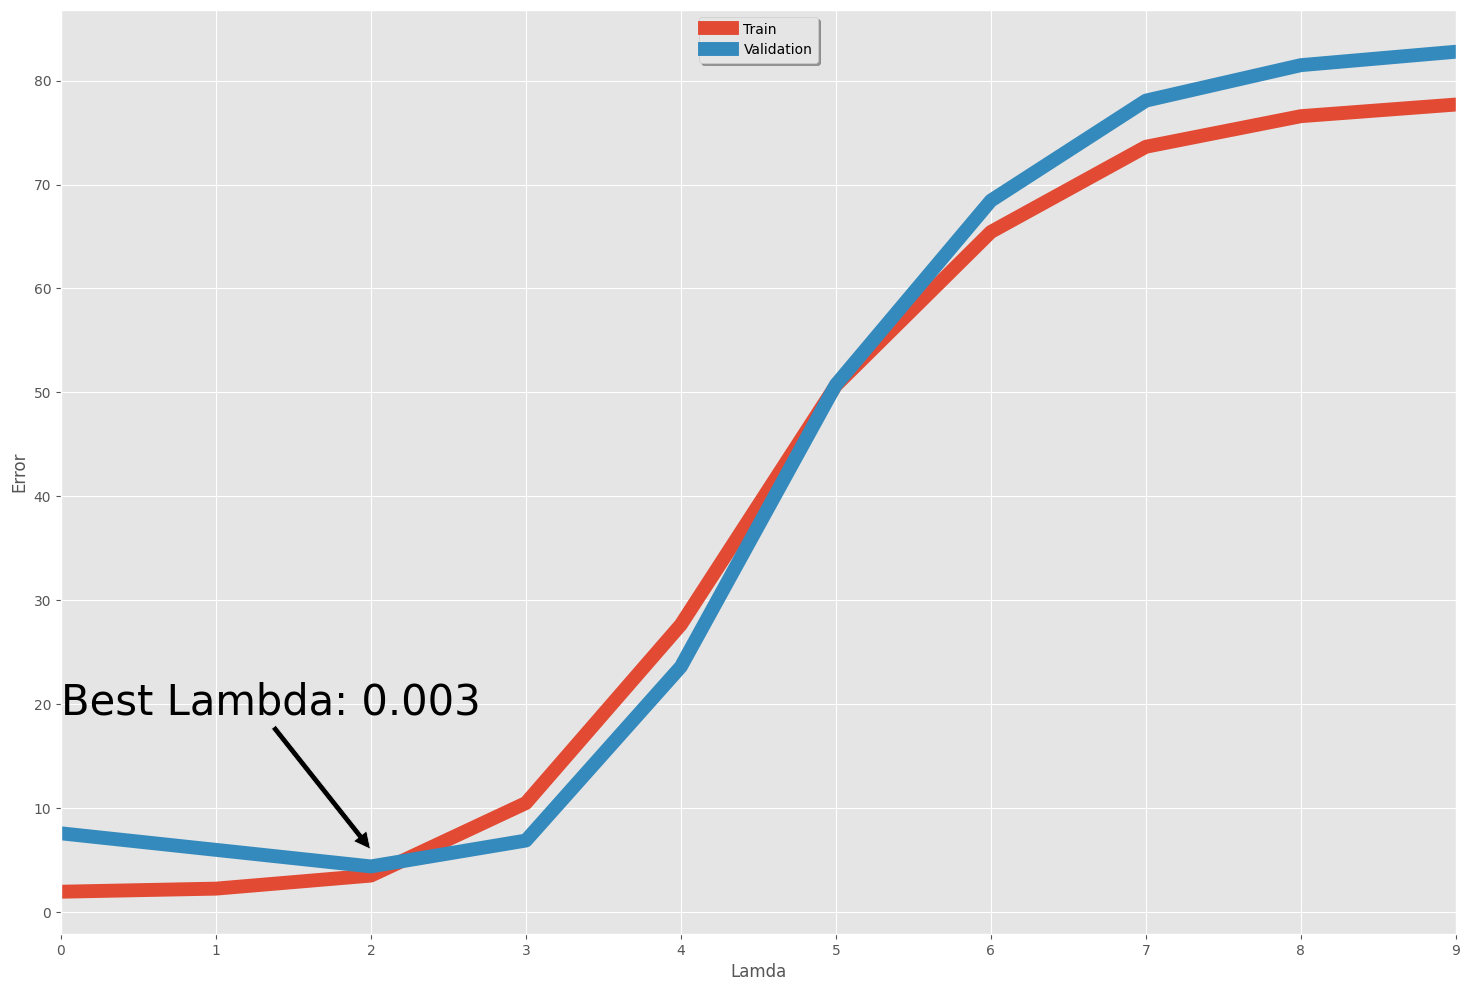

In [25]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(np.arange(lambda_vec.min(), lambda_vec.max()), train_error_lamb, label = 'Train', linewidth=10)
ax.plot(np.arange(lambda_vec.min(), lambda_vec.max()), validation_error_lamb,  label= 'Validation', linewidth=10)
ax.annotate("Best Lambda: %.3f" % best_lamda, xy=(2, 6), xytext=(0.001, 19), size=30,
            arrowprops=dict(facecolor='black', shrink=0.005))
plt.ylabel('Error')
plt.xlabel('Lamda')
plt.xlim(0,9)
legend = ax.legend(loc='upper center', shadow=True)
plt.show()

The best $\lambda$ to choose is that value of $\lambda$ that causes the least error on the validation set. In this case is the third value (in the plot is shown that is the second value, but it is actually the third since the index starts from zero) from our *lambda_vec*, which is 0.003.

In [26]:
validation_error_lamb

array([[ 7.58127919],
       [ 5.98824572],
       [ 4.39488179],
       [ 6.8846358 ],
       [23.61431369],
       [50.74367746],
       [68.45252854],
       [78.07489413],
       [81.48716129],
       [82.77865759]])

It can be seen that the least error value for the validation set is the third (4.17235022).

### Computing test set error

Now that we have tuned our $\lambda$ parameter we can run our model on the test set.

In [27]:
initial_theta = np.ones((X_poly.shape[1], 1))
lamb = 0.003
alpha = 0.001
iterations = 10000

theta_optimal, J_history_poly = gradientDescent(X_poly, y, initial_theta, alpha, iterations, lamb)

test_error = costFunctionReg(theta_optimal, X_poly_test, y_test, 0)
print("The test error at the optimal lambda = 0.003 is equal to %.2f" % test_error)

The test error at the optimal lambda = 0.003 is equal to 3.14


/var/folders/26/pjvmws_s7xxbzf69k0n7_8p80000gp/T/ipykernel_3364/3786010578.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("The test error at the optimal lambda = 0.003 is equal to %.2f" % test_error)


/var/folders/26/pjvmws_s7xxbzf69k0n7_8p80000gp/T/ipykernel_3364/4191164049.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X = np.arange(min_X - 15, max_X + 15, 0.05).reshape(-1,1)


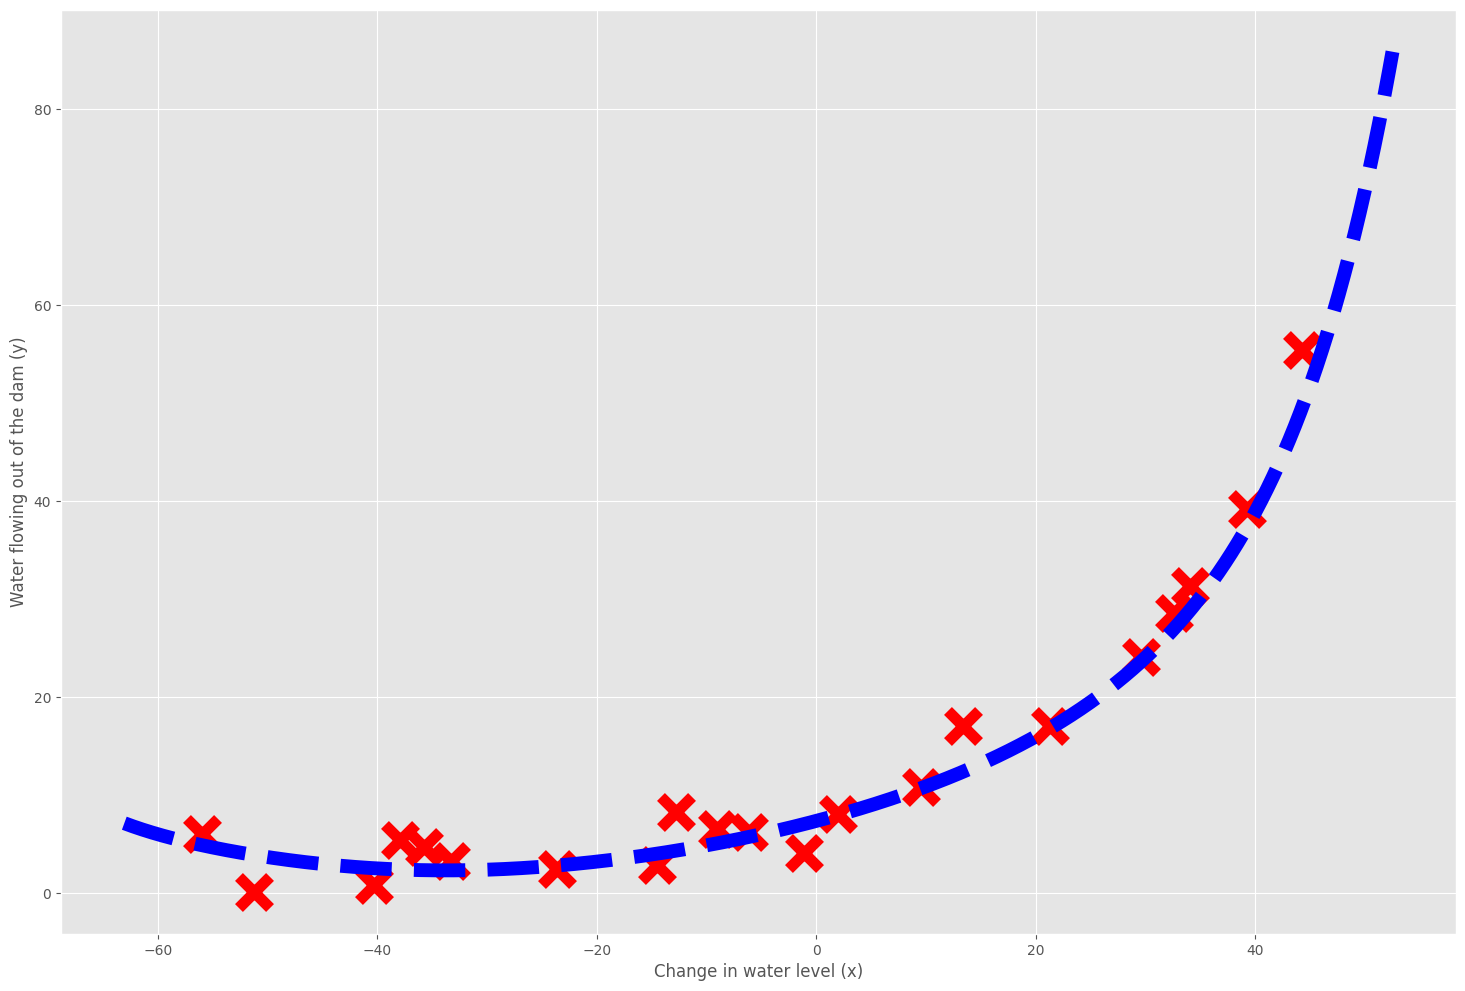

In [28]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1) 
ax.scatter(X_test, y_test, s=500, marker='x',color='r',linewidths=8)
X_fit, X_poly_fit = plotFit(min(X), max(X), mean, sigma, p)
ax.plot(X_fit, np.dot(X_poly_fit, theta_optimal), '--', color='blue', linewidth=10)
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.show()

As it can be seen, the polynomial fit follows the data trend well! What abou the learning curve? Let's plot them!

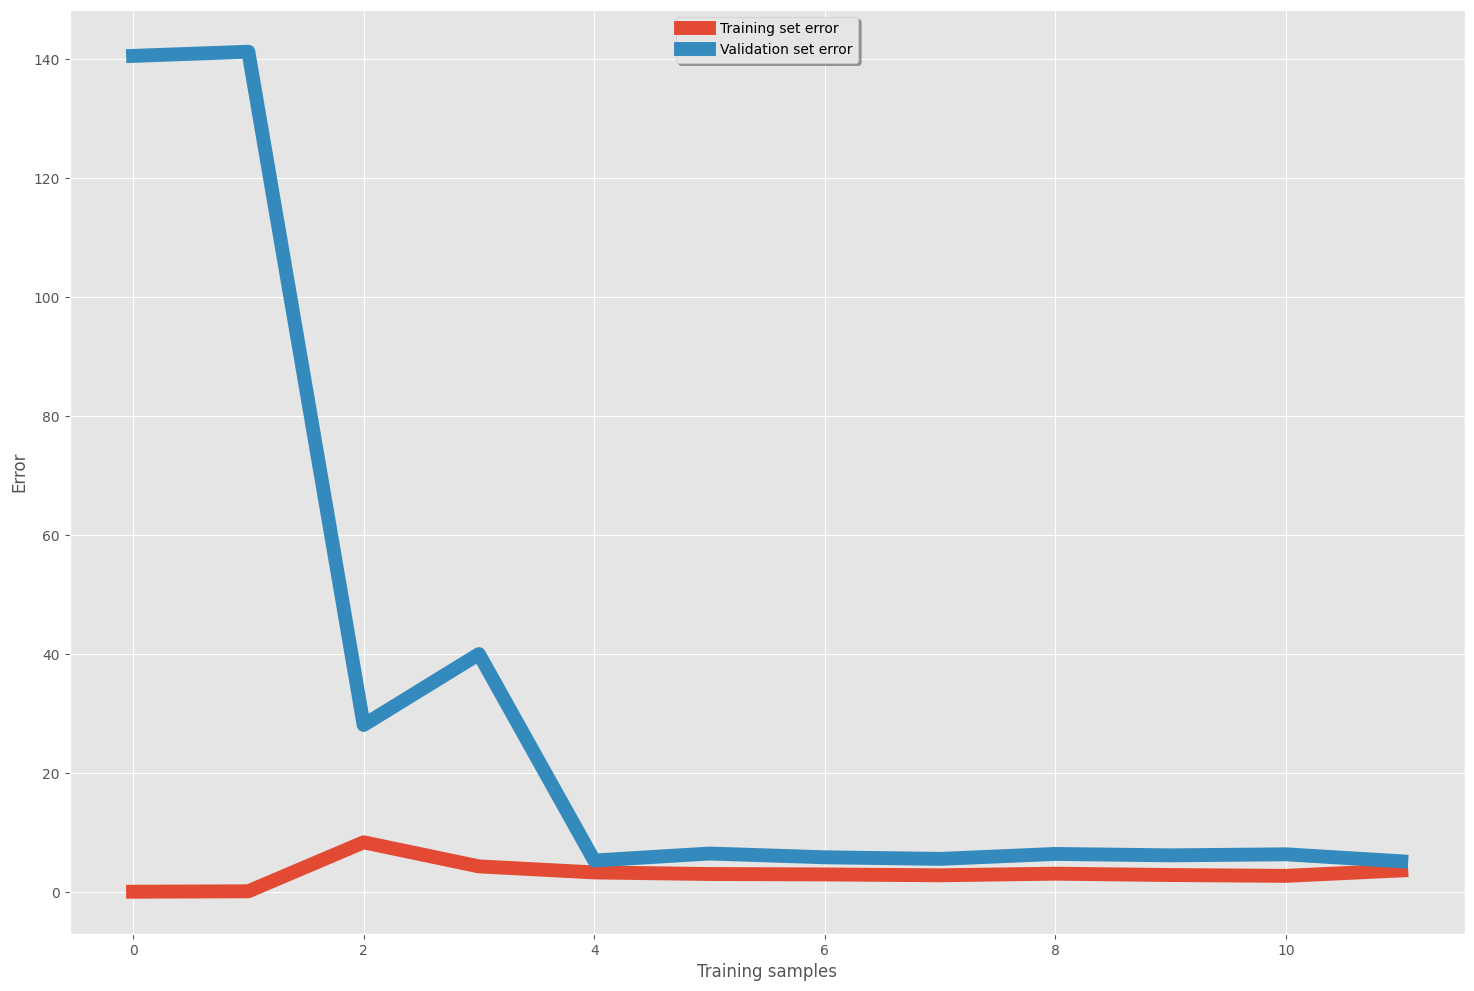

In [29]:
error_train_poly, error_val_poly = learningCurve(X_poly, y, X_poly_val, y_val, lamb)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(range(X_poly.shape[0]), error_train_poly, label = 'Training set error', linewidth=10)
ax.plot(range(X_poly.shape[0]), error_val_poly, label = 'Validation set error', linewidth=10)
legend = ax.legend(loc='upper center', shadow=True)
plt.ylabel('Error')
plt.xlabel('Training samples')
plt.show()

We can notice that both the cross validation and trainig set error converge to a relatively low value and that there is no evident gab between them. 

So we managed to create a model with no bias and no variance! Great!